In [1]:

from autocvd import autocvd
autocvd(num_gpus = 1)
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the GPU you want to use, or leave empty for CPU


from tqdm import tqdm
import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding
jax.config.update("jax_enable_x64", True)


import numpy as np
from astropy import units as u

from odisseo import construct_initial_state
from odisseo.dynamics import DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams
from odisseo.option_classes import MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.utils import projection_on_GD1

#import flowjax, use for the loss function
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data

#optimization
from jaxopt import ScipyMinimize, LBFGS
import optax
import optimistix as optx

from chainconsumer import Chain, ChainConsumer, Truth, make_sample
import pandas as pd


import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

# Generate the target simulation 

(-250.0, 250.0)

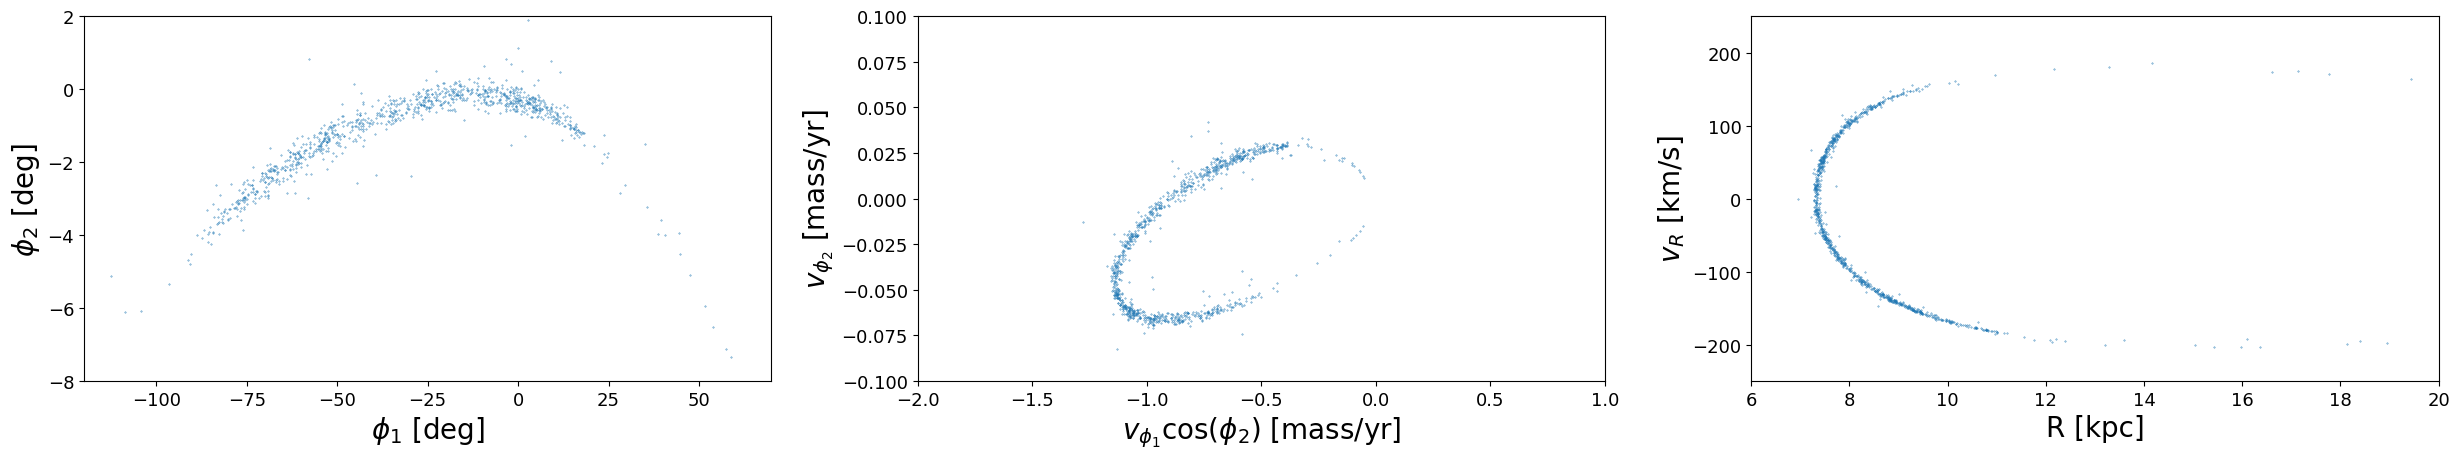

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  

#set the config, we cannot differentiate with respect to the config
config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = False, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

# set the simulation parameters, we can differentiate with respect to these parameters
params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

#the center of mass has the same config and params as the main simulation but it needs to be integrated backwards in time 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#random key for JAX
key = random.PRNGKey(1)
#Final position and velocity of the center of mass
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
mass_com = jnp.array([params.Plummer_params.Mtot]) 

#we construmt the initial state of the com 
initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
#we run the simulation backwards in time for the center of mass
final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=params_com)
#we calculate the final position and velocity of the center of mass
pos_com = final_state_com[:, 0]
vel_com = final_state_com[:, 1]

#we construct the initial state of the Plummer sphere
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)
#we add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com
#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities, )
#run the simulation
final_state = time_integration(initial_state_stream, mass, config=config, params=params)

#projection on the GD1 stream
stream = projection_on_GD1(final_state, code_units=code_units,)

#plot to check the stream
R = stream[:, 0]  # kpc
phi1 = stream[:, 1]  # deg
phi2 = stream[:, 2]  # deg
vR = stream[:, 3]  # km/s
v1_cosphi2 = stream[:, 4]  # mass/yr
v2 = stream[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


In [3]:
stream_target = stream

# Add observational noise

This is fully differentiable and jittable, exept for the training, since in the training a varying size array is passed.
In theory its possible to remove this part, but the number of stars is quite large when concatanted with the the selected stream, 
so the training is very long and it would require to change the NaN values with something outside of the observational window and
using a constrained Normalizing Flow (https://danielward27.github.io/flowjax/examples/constrained.html)

 25%|██▌       | 25/100 [00:15<00:46,  1.60it/s, train=5.82, val=6.16 (Max patience reached)]


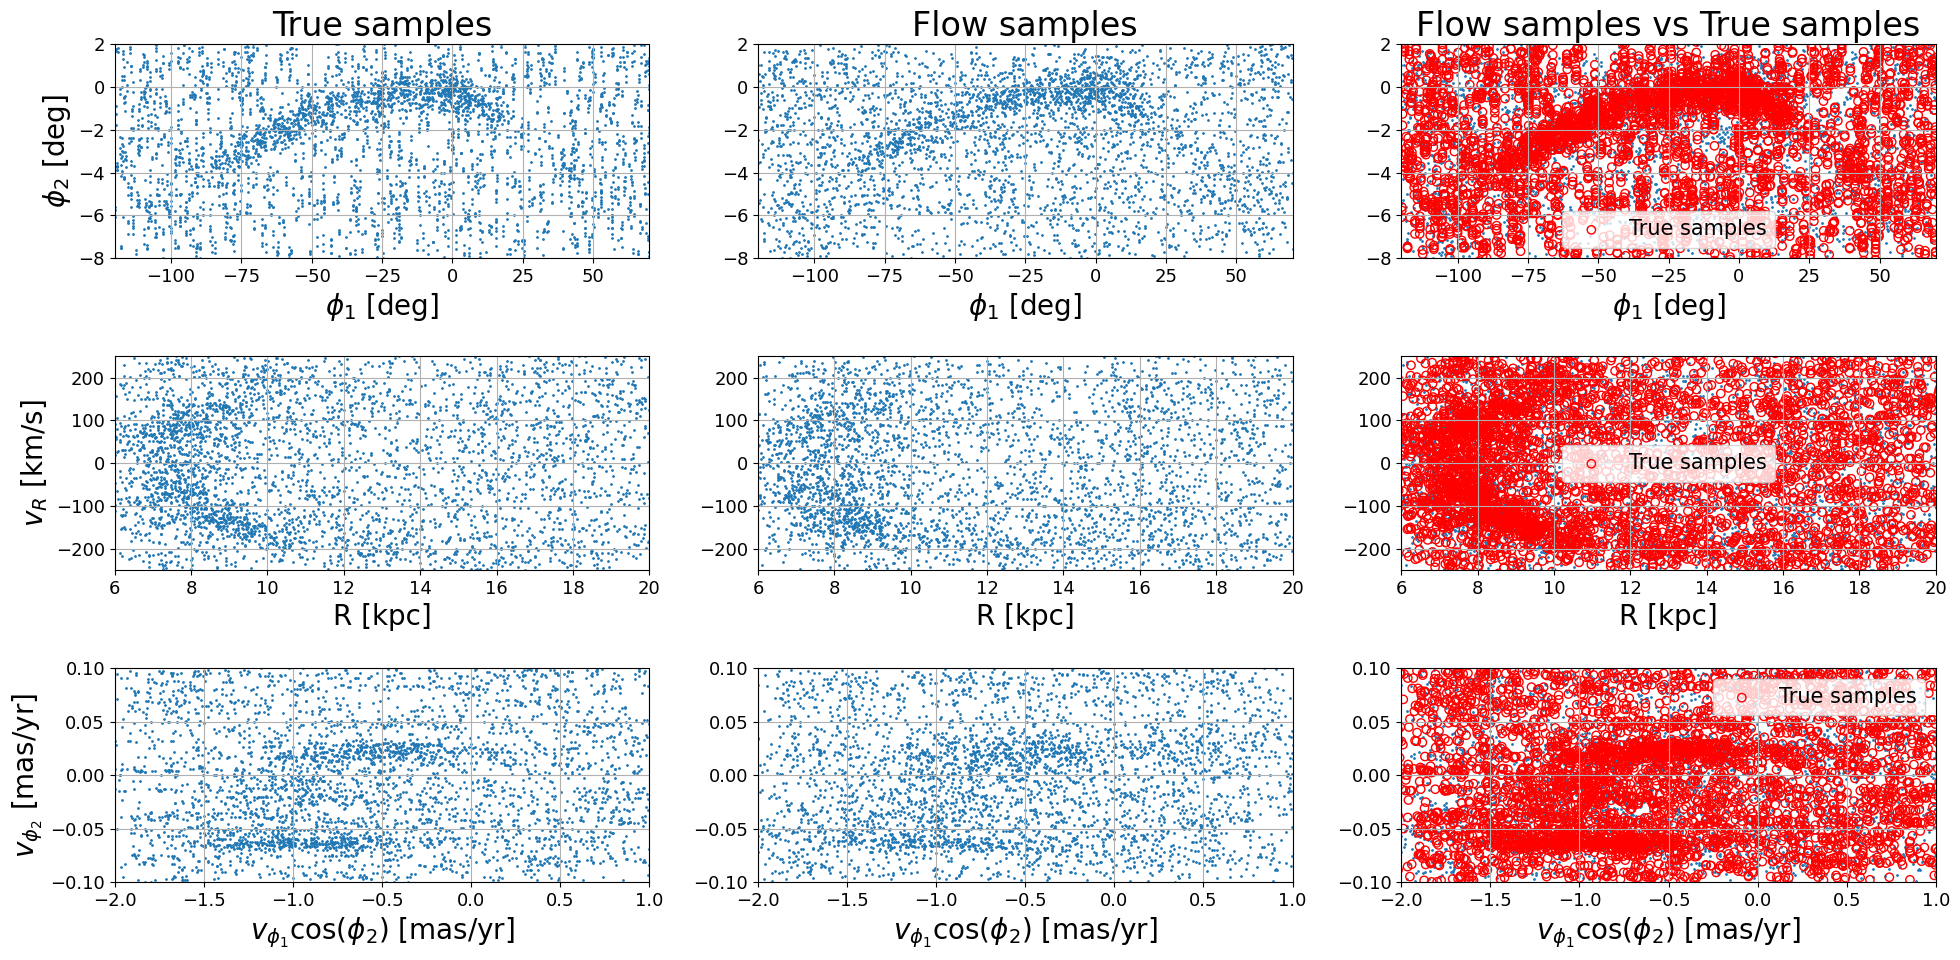

In [6]:
#Bimodal sampling
@jit
def selection_function(stream_star, p, key):
    # Apply selection criteria
    return jnp.where(jax.random.uniform(key=key, shape=1) < p, stream_star, jnp.nan)

# Generate a random background star position
@jit 
def background_assignement(key):
    return jax.random.uniform(key=key, shape=(6,),
                              minval=jnp.array([6, -120, -8, -250, -2., -0.10]),
                             maxval=jnp.array([20, 70, 2, 250, 1.0, 0.10]))

# Select stars from the stream based on Bimodal sampling
key = random.PRNGKey(42)
keys = random.split(key, stream.shape[0])
p = jnp.ones(shape=(stream.shape[0]))* 0.95
selected_stream = jax.vmap(selection_function, )(stream, p, keys)

# Nbackground star contamination
N_background = int(1e6)
#Generate the probability of selectin a background star
background_selected_probability = jnp.where(jax.random.uniform(key=key, shape=(N_background,)) < 1e-3, 1.0, 0.0)
keys = random.split(key, N_background)
selected_background = jax.vmap(lambda key, background_star_probability: jnp.where(background_star_probability, background_assignement(key), jnp.nan))(keys, background_selected_probability)

# Combine the selected stream and background stars
stream = jnp.concatenate((selected_stream, selected_background), axis=0)

#add gaussian noise to the stream, same as in Albatross paper (https://arxiv.org/pdf/2304.02032)
noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
stream = stream + jax.random.normal(key=jax.random.key(0), shape=stream.shape) * noise_std

stream_mean = jnp.nanmean(stream, axis=0)
stream_std = jnp.nanstd(stream, axis=0)
stream = (stream - stream_mean) / stream_std  # Standardize the data

stream_target = stream[~jnp.isnan(stream)].reshape(-1, 6)  # Remove NaN values for training

# Assign a new out of the observational windows value to the NaN values, and use constrain support NF, not implemented yet
# stream = jax.vmap(lambda stream_star: jnp.where(jnp.isnan(stream_star), jnp.ones((6))*100, stream_star))(stream)

#rng
rng = jax.random.key(0)

# create the flow
subkey, rng = jax.random.split(rng)
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(stream.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

#we train only on the non NaN values of the stream
key, subkey = jax.random.split(key)
flow, losses = fit_to_data(subkey, flow, stream[~jnp.isnan(stream)].reshape(-1, 6), learning_rate=1e-3)


# Check the flow sampling
stream_plot = stream[~jnp.isnan(stream)].reshape(-1, 6) * stream_std + stream_mean
key, subkey = jax.random.split(jax.random.key(1))
x_samples = flow.sample(subkey, (stream_plot.shape[0],))

# Transform the samples back to the original scale
x_samples_plot = x_samples * stream_std + stream_mean

fig = plt.figure(figsize=(20, 10), tight_layout=True)
ax = fig.add_subplot(331)
ax.scatter(stream_plot[:, 1], stream_plot[:, 2], s=1 )
ax.set_title("True samples")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.grid('dotted')
ax = fig.add_subplot(332)
ax.scatter(x_samples_plot[:, 1], x_samples_plot[:, 2], s=1)
ax.set_title("Flow samples")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.set_xlabel("$\phi_1$ [deg]")
ax.grid('dotted')
ax = fig.add_subplot(333)
ax.set_title("Flow samples vs True samples")
ax.scatter(x_samples_plot[:, 1], x_samples_plot[:, 2], s=1)
ax.scatter(stream_plot[:, 1], stream_plot[:, 2],  marker='o', facecolors='none',  color='r', label='True samples')
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.legend()
ax.set_xlabel("$\phi_1$ [deg]")
ax.grid('dotted')

ax = fig.add_subplot(334)
ax.scatter(stream_plot[:, 0], stream_plot[:, 3],s=1 )
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.grid('dotted')
ax = fig.add_subplot(335)
ax.scatter(x_samples_plot[:, 0], x_samples_plot[:, 3], s=1)
ax.set_xlabel("R [kpc]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.grid('dotted')
ax = fig.add_subplot(336)
ax.scatter(x_samples_plot[:, 0], x_samples_plot[:, 3], s=1)
ax.scatter(stream_plot[:, 0], stream_plot[:, 3], marker='o', facecolors='none', color='r', label='True samples')
ax.set_xlabel("R [kpc]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.legend()
ax.grid('dotted')

ax = fig.add_subplot(337)
ax.scatter(stream_plot[:, 4], stream_plot[:, 5], s=1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")      
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax = fig.add_subplot(338)
ax.scatter(x_samples_plot[:, 4], x_samples_plot[:, 5], s=1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax = fig.add_subplot(339)
ax.scatter(x_samples_plot[:, 4], x_samples_plot[:, 5], s=1)
ax.scatter(stream_plot[:, 4], stream_plot[:, 5], marker='o', facecolors='none', color='r', label='True samples')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax.legend()
plt.tight_layout()


# Differentiable Loss and optimization

## Loss for all the parameters

In [33]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))



@jit
def time_integration_fix_position_grad(t_end, 
                                       M_plummer,
                                       a_plummer,
                                       M_NFW,
                                       r_s_NFW,
                                       M_MN,
                                       a_MN,
                                       key):

    #Creation of the Plummer sphere requires a key 
    # key = random.PRNGKey(key)
    key_Plummer, key_selection, key_background, key_noise = random.split(key, 4)
    
    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    #parameters of the stream
    new_params = params._replace(
                t_end = t_end,
                Plummer_params=params.Plummer_params._replace(
                    Mtot=M_plummer,
                    a=a_plummer
                ),
                NFW_params=params.NFW_params._replace(
                    Mvir=M_NFW,
                    r_s=r_s_NFW
                ),
                MN_params=params.MN_params._replace(
                    M=M_MN,
                    a=a_MN
                ))
    #parameters of the center of mass
    #we set the t_end to be negative, so we run the simulation backwards in time
    new_params_com = new_params._replace(t_end=-t_end,)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_Plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)

    #Stream selection success
    selected_stream = stream

    # #background contamination
    N_background = int(1e6)
    N_background = int(N_background * 1e-3)
    # selected_background = jax.vmap(background_assignement, )(random.split(key=key_background, num=N_background))

    # Combine the selected stream and background stars
    # stream = jnp.concatenate((selected_stream, selected_background), axis=0)

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D

    #use the median of the pairwise distance as the bandwidth
    @jit
    def compute_median_distance(X, Y):
        """Compute median pairwise distance between datasets"""
        # Sample subset for efficiency (important for large datasets)

        X_sample = X
        Y_sample = Y
        
        # Compute all pairwise distances
        distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(Y_sample))(X_sample)
        
        # Return median distance
        return jnp.median(distances.flatten())
    
    @jit 
    def compute_mmd(sim_norm, target_norm, sigmas):
        xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
        yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
        xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
        return xx + yy - 2 * xy
    
    # Method 1: Median multiscale
    median_dist = compute_median_distance(sim_norm, target_norm)
    sigma = median_dist / jnp.sqrt(2)  # Common scaling factor
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy
    # sigmas = jnp.array([sigma/4, sigma/2, sigma, sigma*2, sigma*4]) 

    

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    # sigmas = jnp.array([
    #     jnp.percentile(distance_flat, 10),   # Fine scale
    #     jnp.percentile(distance_flat, 25),   # Small scale  
    #     jnp.percentile(distance_flat, 50),   # Medium scale (median)
    #     jnp.percentile(distance_flat, 75),   # Large scale
    #     jnp.percentile(distance_flat, 90),   # Very large scale
    # ])

    # Adaptive weights based on scale separation
    # scale_weights = jnp.array([0.1, 0.1, 0.3, 0.25, 0.25])
    # scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    # mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    # return mmd_total / len(sigmas)

    return 
    



In [34]:
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = params.t_end * (3/4)
M_plummer = params.Plummer_params.Mtot * (3/4)
Mvir = params.NFW_params.Mvir * (3/4)
r_s_NFW = params.NFW_params.r_s * (3/4)
a_plummer = params.Plummer_params.a * (3/4)
M_MN = params.MN_params.M * (3/4)
a_MN = params.MN_params.a * (3/4)

key = random.PRNGKey(0)
loss, grad = jax.value_and_grad(time_integration_fix_position_grad, 
                                argnums=(0, 1, 2, 3, 4, 5, 6) )(t_end,
                                                                M_plummer,
                                                                a_plummer,
                                                                Mvir,
                                                                r_s_NFW,
                                                                M_MN,
                                                                a_MN,
                                                                key)
# Print the results
print("Gradient of the simulations wrt to initial parameter \n", grad)
print("Loss:\n", loss)  

2025-06-16 09:53:25.860259: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 3.12GiB (3348304598 bytes) by rematerialization; only reduced to 5.06GiB (5435095897 bytes), down from 5.06GiB (5435096537 bytes) originally


Gradient of the simulations wrt to initial parameter 
 (Array(0.63119634, dtype=float64), Array(0.00532226, dtype=float64), Array(-7.16026846, dtype=float64), Array(2.53740851e-08, dtype=float64), Array(-0.70158263, dtype=float64), Array(5.41345241e-08, dtype=float64), Array(-0.15804892, dtype=float64))
Loss:
 0.5038730330079888


# Gradient descend

Lighter then LBFGS but still not possible to go beyong batch_size=1, so for loop is still needed without multiple GPU

In [35]:
# Define parameter bounds
# Define parameter bounds in code units
param_bounds = jnp.array([
    [jnp.log10((0.5 * u.Gyr).to(code_units.code_time).value), 
     jnp.log10((5.0 * u.Gyr).to(code_units.code_time).value)],           # t_end (0.5-5 Gyr)
    
    [jnp.log10((10**3.0 * u.Msun).to(code_units.code_mass).value), 
     jnp.log10((10**4.5 * u.Msun).to(code_units.code_mass).value)],      # log10(M_plummer) (10^3 - 10^4.5 Msun)
    
    [jnp.log10(params.Plummer_params.a*0.25), 
     jnp.log10(params.Plummer_params.a*2)],                              # log10(a_plummer) - already in code units
    
    [jnp.log10((params.NFW_params.Mvir*0.25 * u.Msun).to(code_units.code_mass).value), 
     jnp.log10((params.NFW_params.Mvir*2 * u.Msun).to(code_units.code_mass).value)],         # log10(M_NFW) (10^10 - 10^12 Msun)
    
    [jnp.log10((params.NFW_params.r_s * 0.25 * u.kpc).to(code_units.code_length).value), 
     jnp.log10((params.NFW_params.r_s * 2 * u.kpc).to(code_units.code_length).value)],        # log10(r_s_NFW) (5-50 kpc)
    
    [jnp.log10((params.MN_params.M * 0.25 * u.Msun).to(code_units.code_mass).value), 
     jnp.log10((params.MN_params.M * 2 * u.Msun).to(code_units.code_mass).value)],         # log10(M_MN)
    
    [jnp.log10((params.MN_params.a * 0.25 * u.kpc).to(code_units.code_length).value), 
     jnp.log10((params.MN_params.a * 2 * u.kpc).to(code_units.code_length).value)],        # log10(a_MN) (1-10 kpc)
])

def tanh_transform(unbounded_params, bounds):
    """
    Transform unbounded parameters to bounded log-space parameters using tanh
    Better than sigmoid: more symmetric, better gradients, more stable
    """
    lower, upper = bounds[:, 0], bounds[:, 1]
    # tanh maps (-∞, +∞) to (-1, +1), then we scale to (lower, upper)
    return lower + (upper - lower) * (jnp.tanh(unbounded_params) + 1) / 2

def inverse_tanh_transform(bounded_log_params, bounds):
    """
    Convert bounded log-space parameters back to unbounded space
    Much more stable than inverse sigmoid
    """
    lower, upper = bounds[:, 0], bounds[:, 1]
    # Normalize to (-1, 1)
    normalized = 2 * (bounded_log_params - lower) / (upper - lower) - 1
    # Clamp to avoid numerical issues (tanh is more forgiving)
    normalized = jnp.clip(normalized, -0.999, 0.999)
    return jnp.arctanh(normalized)

@jit
def time_integration_fix_position_grad_ScipyMinimize(param, key):
    # param = inverse_tanh_transform(param, param_bounds)
    # param = sigmoid_transform(param, param_bounds)
    t_end, M_plummer, a_plummer, Mvir, r_s_NFW, M_MN, a_MN = 10**param
    # t_end = 10**t_end
    # M_plummer = 10**M_plummer
    # a_plummer = 10**a_plummer
    # Mvir = 10**Mvir
    # r_s_NFW = 10**r_s_NFW
    # M_MN = 10**M_MN
    # a_MN = 10**a_MN
    
    return time_integration_fix_position_grad(t_end, 
                                              M_plummer,
                                              a_plummer,
                                              Mvir,
                                              r_s_NFW,
                                              M_MN,
                                              a_MN,
                                              key)


In [36]:
parameter_value = jax.random.uniform(key=key, 
                                    shape=(50, 7), 
                                    minval=jnp.array([0.5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    10**3.0 * u.Msun.to(code_units.code_mass), # Plummer mass
                                                    params.Plummer_params.a*(1/4),
                                                    params.NFW_params.Mvir*(1/4),
                                                    params.NFW_params.r_s*(1/4), 
                                                    params.MN_params.M*(1/4), 
                                                    params.MN_params.a*(1/4),]), 
                                                    
                                    maxval=jnp.array([5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    10**4.5 * u.Msun.to(code_units.code_mass), #Plummer mass
                                                    params.Plummer_params.a*(8/4),
                                                    params.NFW_params.Mvir*(8/4), 
                                                    params.NFW_params.r_s*(8/4), 
                                                    params.MN_params.M*(8/4), 
                                                    params.MN_params.a*(8/4),])) 

In [45]:
# We pick gradient descent for pedagogical and visualization reasons.
# In practice one would use e.g. Levenberg-Marquardt from the
# optimistix package.

# from functools import partial
# @partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    # xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
    xlist = []
    x = x_init
    loss_list = []
    # loss_list = jnp.zeros(max_iter + 1)

    xlist.append(x)
    # xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

    # ADAM optimizer
    optimizer = optax.adam(learning_rate=learning_rate)
    optimizer_state = optimizer.init(x)

    ##SCHEDULE FREE ADAM
    # learning_rate_fn = optax.warmup_constant_schedule(peak_value=learning_rate, warmup_steps=10, init_value=0.0)
    # optimizer = optax.adam(learning_rate_fn, b1=0.)
    # optimizer = optax.contrib.schedule_free(optimizer, learning_rate_fn, b1=0.9)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAMW
    # optimizer = optax.contrib.schedule_free_adamw(learning_rate)
    # optimizer_state = optimizer.init(x)


    for _ in tqdm(range(max_iter)):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x, key)
        loss_list.append(loss)
        # loss_list = loss_list.at[_].set(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(f_grad, optimizer_state, x)
        x = optax.apply_updates(x, updates)
        key = random.split(key, 1)[0]  # Update the key for the next iteration
        xlist.append(x)
        # xlist = xlist.at[_ + 1].set(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break
    
    return x, xlist, loss_list

In [38]:
# all_loss = []
# all_xlist =[]
# for i in range(parameter_value.shape[0]):
#     initial_guess = parameter_value[i]
#     x1, xlist, loss_list = gradient_descent_optimization(
#         time_integration_fix_position_grad_ScipyMinimize, 
#         jnp.log10(initial_guess),  
#         key, 
#         learning_rate=0.01, 
#         tol=1e-6, 
#         max_iter=50
#     )
#     all_loss.append(loss_list)
#     all_xlist.append(xlist)


Text(0, 0.5, 'NFW_M (Msun)')

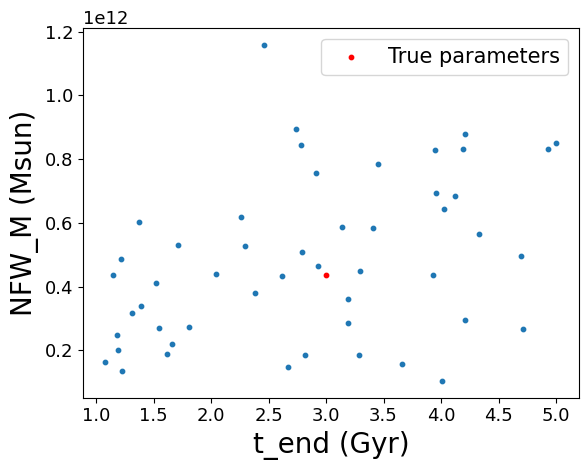

In [ ]:
# all_minimum_loss = np.array(np.min(l) for l in all_loss)
# all_x_minimum = np.array([x[np.argmin(l)] for x, l in zip(all_xlist, all_loss)])

# plt.scatter(10**all_x_minimum[:, 0]*code_units.code_time.to(u.Gyr), 
#             10**all_x_minimum[:, 3]*code_units.code_mass.to(u.Msun), s=10)

# plt.scatter(params.t_end*code_units.code_time.to(u.Gyr),
#             params.NFW_params.Mvir*code_units.code_mass.to(u.Msun), s=10, color='red', label='True parameters')
# plt.legend()
# plt.xlabel("t_end (Gyr)")
# plt.ylabel("NFW_M (Msun)")



In [46]:
# initial_guess = parameter_value[0]
initial_guess = jnp.array([params.t_end*3/4, params.Plummer_params.Mtot*3/4,
                           params.Plummer_params.a, 
                           params.NFW_params.Mvir, 
                           params.NFW_params.r_s, 
                           params.MN_params.M, 
                           params.MN_params.a], dtype=jnp.float64)
x1, xlist, loss_list = gradient_descent_optimization(
    time_integration_fix_position_grad_ScipyMinimize, 
    jnp.log10(initial_guess),  
    key, 
    learning_rate=0.01,
    tol=1e-8, 
    max_iter=100
)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:57<00:00,  2.37s/it]


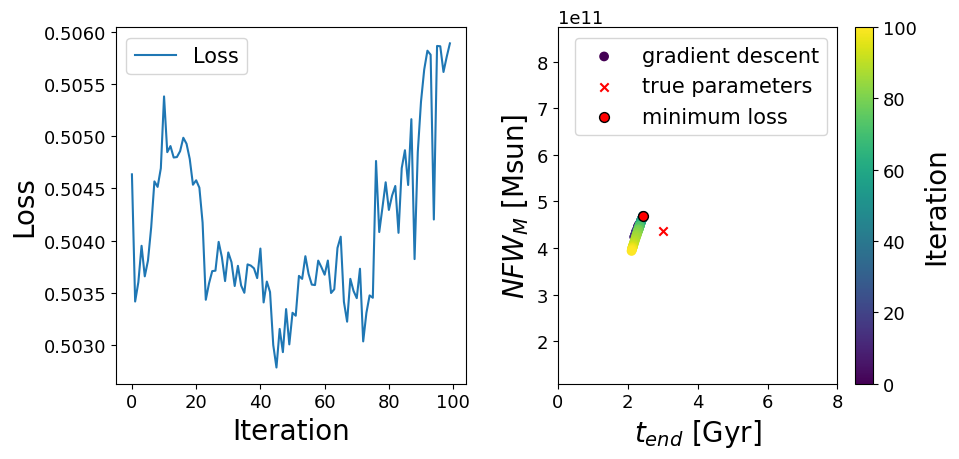

In [47]:
xlist = jnp.array(xlist)
loss_list = jnp.array(loss_list)

fig = plt.figure(figsize=(10, 5), tight_layout=True)
ax = fig.add_subplot(121)

ax.plot(loss_list, label='Loss')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax = fig.add_subplot(122)
# Plot the results of the optimization # Filter out negative t_end values
s = ax.scatter(10**xlist[:, 0] * code_units.code_time.to(u.Gyr), 
               10**xlist[:, 3] * code_units.code_mass.to(u.Msun), c=np.arange(0, xlist.shape[0]), label='gradient descent')
# xlist_log = jax.vmap(lambda x: inverse_tanh_transform(x, param_bounds))(xlist)
# x_list_converted = 10**xlist_log
# s = ax.scatter(x_list_converted[:, 0] * code_units.code_time.to(u.Gyr),
#                 x_list_converted[:, 3]* code_units.code_mass.to(u.Msun), 
#                 c=np.arange(0, xlist.shape[0]), label='gradient descent')
ax.scatter(params.t_end * code_units.code_time.to(u.Gyr), params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) , label='true parameters', marker='x', color='red')
min_loss = jnp.argmin(loss_list)
ax.scatter(10**xlist[min_loss, 0] * code_units.code_time.to(u.Gyr),
            10**xlist[min_loss, 3] * code_units.code_mass.to(u.Msun), 
            marker='o', color='red', label='minimum loss', s=50, edgecolor='black')
ax.set_xlabel('$t_{end}$ [Gyr]')
ax.set_ylabel('$NFW_{M}$ [Msun]')
# ax.set_yscale('log')
ax.set_xlim(0, 8)
ax.set_ylim(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) * 0.25, params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) * 2)
fig.colorbar(s, label='Iteration', ax=ax)
ax.legend()

In [25]:
10**xlist[min_loss, 0] * code_units.code_time.to(u.Gyr),
10**xlist[min_loss, 3] * code_units.code_mass.to(u.Msun)

Array(9.01420244e+11, dtype=float64)

## 2D Case

In [4]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def kde_loss(sim_norm, target_norm):
    # H = (4/(6+2))**(1/(6+4))*len(sim_norm)**(-1/(6+4))*jnp.diag(jnp.std(sim_norm, axis=0))
    H = jnp.diag(jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0]))

    @jit
    def likelihood_single_star(observed_star):
        return jnp.mean(jax.vmap(lambda mean: jax.scipy.stats.multivariate_normal.pdf(observed_star, mean, H))(sim_norm))
    
    # Compute the likelihood for each star in the stream
    likelihoods = jax.vmap(likelihood_single_star)(target_norm, )
    # Return the negative log likelihood
    return -jnp.sum(jnp.log(likelihoods))

# @jit
# def kde_loss(sim_norm, target_norm):
#     """Robust KDE loss with numerical safeguards"""
    
#     # # More conservative bandwidth
#     n = len(sim_norm)
#     d = 6
    
#     # # Use standard deviation with minimum threshold
#     # std_vals = jnp.std(sim_norm, axis=0)
#     # std_vals = jnp.maximum(std_vals, 0.01)  # Prevent too small bandwidths
    
#     # # Scott's rule (more conservative than Silverman)
#     # bandwidth = jnp.power(n, -1/(d+4)) * std_vals
#     # H = jnp.diag(bandwidth**2)
#     H = jnp.diag(jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0]))
    
#     # Add regularization to prevent singular matrix
#     H = H + 1e-6 * jnp.eye(d)
    
#     @jit
#     def likelihood_single_star(observed_star):
#         def robust_pdf(mean_point):
#             diff = observed_star - mean_point
#             try:
#                 return jax.scipy.stats.multivariate_normal.pdf(observed_star, mean_point, H)
#             except:
#                 # Fallback calculation
#                 inv_H = jnp.linalg.inv(H)
#                 det_H = jnp.linalg.det(H)
#                 exponent = -0.5 * jnp.dot(diff, jnp.dot(inv_H, diff))
#                 normalizer = jnp.power(2 * jnp.pi, d/2) * jnp.sqrt(jnp.abs(det_H))
#                 return jnp.exp(jnp.clip(exponent, -50, 50)) / (normalizer + 1e-10)
        
#         pdfs = jax.vmap(robust_pdf)(sim_norm)
#         return jnp.mean(pdfs) + 1e-12  # Prevent exactly zero
    
#     likelihoods = jax.vmap(likelihood_single_star)(target_norm)
    
#     # Robust log-likelihood computation
#     log_likelihoods = jnp.log(jnp.clip(likelihoods, 1e-12, jnp.inf))
#     nll = -jnp.sum(log_likelihoods)
    
#     # Return finite value if NaN
#     return jnp.where(jnp.isfinite(nll), nll, 1e8)

# @jit
# def adaptive_kde_loss(sim_norm, target_norm):
#     """KDE loss with adaptive full covariance matrix"""
    
#     n = len(sim_norm)
#     d = sim_norm.shape[1]  # 6D
    
#     # Scott's rule for bandwidth
#     bandwidth_factor = jnp.power(n, -1.0/(d+4))
    
#     # Use empirical covariance of simulation data as base
#     sim_cov = jnp.cov(sim_norm.T)
    
#     # Scale by bandwidth factor
#     H = (bandwidth_factor**2) * sim_cov
    
#     # Add regularization
#     H = H + 1e-6 * jnp.eye(d)
    
#     @jit
#     def likelihood_single_star(observed_star):
#         def robust_pdf(mean_point):
#             return jax.scipy.stats.multivariate_normal.pdf(
#                 observed_star, mean_point, H
#             )
        
#         pdfs = jax.vmap(robust_pdf)(sim_norm)
#         return jnp.mean(pdfs) + 1e-12
    
#     likelihoods = jax.vmap(likelihood_single_star)(target_norm)
#     log_likelihoods = jnp.log(jnp.clip(likelihoods, 1e-12, jnp.inf))
#     nll = -jnp.sum(log_likelihoods)
    
#     return jnp.where(jnp.isfinite(nll), nll, 1e8)


@jit
def spline_loss(sim_norm, target_norm):
    phi2_target = jnp.interp(target_norm[:, 2], sim_norm[:, 1], sim_norm[:, 2])

    # Calculate the spline loss as the mean squared error between the interpolated phi2 and the target phi2
    loss = jnp.mean((phi2_target - target_norm[:, 2])**2)
    return loss


@jit
def time_integration_fix_position_2Dcase_grad(t_end, 
                                            M_NFW,
                                            key):

    #Creation of the Plummer sphere requires a key 
    # key = random.PRNGKey(key)
    key_Plummer, key_selection, key_background, key_noise = random.split(key, 4)
    
    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    #parameters of the stream
    new_params = params._replace(
                t_end = t_end,
                NFW_params=params.NFW_params._replace(
                    Mvir=M_NFW,
                ),)
    #parameters of the center of mass
    #we set the t_end to be negative, so we run the simulation backwards in time
    new_params_com = new_params._replace(t_end=-t_end,)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_Plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)

    #Stream selection success
    selected_stream = stream

    # # #background contamination
    # N_background = int(1e6)
    # N_background = int(N_background * 1e-3)
    # selected_background = jax.vmap(background_assignement, )(random.split(key=key_background, num=N_background))

    # Combine the selected stream and background stars
    # stream = jnp.concatenate((selected_stream, selected_background), axis=0)



    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    def normalize_stream_robust(stream, bounds):
        """Robust normalization that handles out-of-bounds data"""
        
        # Clip data to bounds first
        clipped_stream = jnp.clip(stream, bounds[:, 0], bounds[:, 1])
        
        # Then normalize to [0,1]
        normalized = (clipped_stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
        
        return normalized
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    sim_norm = normalize_stream_robust(stream, bounds)
    target_norm = normalize_stream_robust(stream_target, bounds)

    sim_norm = stream
    target_norm = stream_target
    
    # #use the median of the pairwise distance as the bandwidth
    # @jit
    # def compute_median_distance(X, Y):
    #     """Compute median pairwise distance between datasets"""
    #     # Sample subset for efficiency (important for large datasets)

    #     X_sample = X
    #     Y_sample = Y
        
    #     # Compute all pairwise distances
    #     distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(Y_sample))(X_sample)
        
    #     # Return median distance
    #     return jnp.median(distances.flatten())
    
    @jit 
    def compute_mmd(sim_norm, target_norm, sigmas):
        xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
        yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
        xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
        return xx + yy - 2 * xy
    
    # Method 1: Median multiscale
    # median_dist = compute_median_distance(sim_norm, target_norm)
    # sigma = median_dist / jnp.sqrt(2)  # Common scaling factor
    # sigmas = jnp.array([sigma/4, sigma/2, sigma, sigma*2, sigma*4]) 
    

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    scale_weights = jnp.array([0.1, 0.2, 0.35, 0.25, 0.1])
    # scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    return mmd_total / len(sigmas)


    # n_sim, n_target = len(stream), len(stream_target)
    # return compute_mmd(sim_norm, target_norm, 0.5 * jnp.power(n_sim + n_target, -1/(6+4)))

    # return adaptive_kde_loss(sim_norm, target_norm)
    # return spline_loss(sim_norm, target_norm)
    # return kde_loss(sim_norm, target_norm)

@jit
def time_integration_fix_position_2Dcase_grad_ScipyMinimize(param, key):
    t_end, M_NFW = 10**param

    return time_integration_fix_position_2Dcase_grad(t_end, 
                                                     M_NFW,
                                                     key)


parameter_value = jax.random.uniform(key=key, 
                                    shape=(2, 2), 
                                    minval=jnp.array([0.5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    params.NFW_params.Mvir*(1/4),]), 
                                                    
                                    maxval=jnp.array([5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                                    params.NFW_params.Mvir*(8/4), ])) 

# from functools import partial
# @partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    # xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
    xlist = []
    x = x_init
    loss_list = []
    # loss_list = jnp.zeros(max_iter + 1)

    xlist.append(x)
    # xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

    # ADAM optimizer
    # optimizer = optax.adam(learning_rate=learning_rate)
    # optimizer_state = optimizer.init(x)

    ##SCHEDULE FREE ADAM
    # learning_rate_fn = optax.warmup_constant_schedule(peak_value=learning_rate, warmup_steps=10, init_value=0.0)
    # optimizer = optax.adam(learning_rate_fn, b1=0.)
    # optimizer = optax.contrib.schedule_free(optimizer, learning_rate_fn, b1=0.9)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAMW
    optimizer = optax.contrib.schedule_free_adamw(learning_rate)
    optimizer_state = optimizer.init(x)


    pbar = tqdm(range(max_iter))

    for _ in pbar:
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x, key)
        loss_list.append(loss)
        # loss_list = loss_list.at[_].set(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(f_grad, optimizer_state, x)
        x = optax.apply_updates(x, updates)
        key = random.split(key, 1)[0]  # Update the key for the next iteration
        xlist.append(x)
        # xlist = xlist.at[_ + 1].set(x)

        # Update progress bar with current loss
        pbar.set_description(f"Loss: {loss:.6f}")
        
        # Check convergence
        # if jnp.linalg.norm(updates) < tol:
        #     break
    
    return x, xlist, loss_list

In [ ]:
initial_guess = parameter_value[0]
x1, xlist, loss_list = gradient_descent_optimization(
    time_integration_fix_position_2Dcase_grad_ScipyMinimize, 
    jnp.log10(initial_guess),  
    key, 
    learning_rate=1, 
    tol=1e-8,
    max_iter=100
)

Loss: 0.073565: 100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


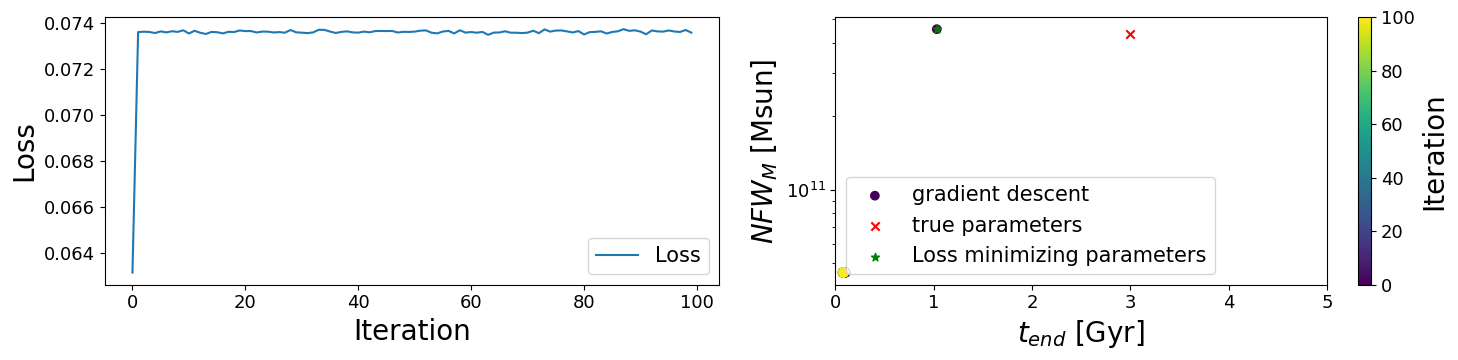

In [8]:
xlist = jnp.array(xlist)
loss_list = jnp.array(loss_list)

fig = plt.figure(figsize=(15, 4), tight_layout=True)
ax = fig.add_subplot(121)

ax.plot(loss_list, label='Loss')
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.legend()
ax = fig.add_subplot(122)
# Plot the results of the optimization # Filter out negative t_end values
s = ax.scatter(10**xlist[:, 0] * code_units.code_time.to(u.Gyr), 
               10**xlist[:, 2] * code_units.code_mass.to(u.Msun), c=np.arange(0, xlist.shape[0]), label='gradient descent')
ax.scatter(params.t_end * code_units.code_time.to(u.Gyr), params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) , label='true parameters', marker='x', color='red')
loss_minimizing_params = xlist[jnp.argmin(loss_list)]
ax.scatter(10**loss_minimizing_params[0] * code_units.code_time.to(u.Gyr), 
               10**loss_minimizing_params[1] * code_units.code_mass.to(u.Msun), 
               marker='*', color='green', label='Loss minimizing parameters')
ax.set_xlabel('$t_{end}$ [Gyr]')
ax.set_ylabel('$NFW_{M}$ [Msun]')
ax.set_yscale('log')
ax.set_xlim(0, 5)
# ax.set_ylim(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) * 0.25, params.NFW_params.Mvir * code_units.code_mass.to(u.Msun) * 2)
fig.colorbar(s, label='Iteration', ax=ax)
ax.legend()

# LevenbergMarquardt

In [7]:
solver = optx.LevenbergMarquardt(
    rtol=1e-6,
    atol=1e-6,
    verbose=frozenset({"step", "accepted", "loss", "step_size"})
)

# initial_guess = parameter_value[0]
initial_gueess = jnp.log10(jnp.array([2.5 * u.Gyr.to(code_units.code_time), # t_end in Gyr
                                        params.NFW_params.Mvir*(2/4),]))  # M_NFW in Msun
init_parms = initial_gueess
sol = optx.least_squares(
    fn=time_integration_fix_position_2Dcase_grad_ScipyMinimize,
    y0=init_parms,
    solver=solver,
    args=(key),
)

2025-06-15 09:17:41.405216: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 19.94GiB (21406172728 bytes) by rematerialization; only reduced to 25.65GiB (27543429278 bytes), down from 25.65GiB (27543429278 bytes) originally


Step: 0, Accepted steps: 0, Steps since acceptance: 0, Loss on this step: 0.0001989487029824236, Loss on the last accepted step: 0.0, Step size: 1.0
Step: 1, Accepted steps: 1, Steps since acceptance: 0, Loss on this step: 0.00013304133964053908, Loss on the last accepted step: 0.0001989487029824236, Step size: 1.0
Step: 2, Accepted steps: 2, Steps since acceptance: 0, Loss on this step: 8.200767194781345e-05, Loss on the last accepted step: 0.00013304133964053906, Step size: 1.0
Step: 3, Accepted steps: 3, Steps since acceptance: 0, Loss on this step: 0.00014484413545163476, Loss on the last accepted step: 8.200767194781345e-05, Step size: 0.25
Step: 4, Accepted steps: 3, Steps since acceptance: 1, Loss on this step: 0.00017673278898968947, Loss on the last accepted step: 8.200767194781345e-05, Step size: 0.0625
Step: 5, Accepted steps: 3, Steps since acceptance: 2, Loss on this step: 0.00012129653062808, Loss on the last accepted step: 8.200767194781345e-05, Step size: 0.015625
Step:

E0615 09:25:41.538847  419455 pjrt_stream_executor_client.cc:2917] Execution of replica 0 failed: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/asyncio/base_events.py", line 645, in run_forever
  File "/export/home/vgiusepp/miniconda3/en

EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/optimistix/_least_squares.py", line 124, in least_squares
    return iterative_solve(
           ^^^^^^^^^^^^^^^^
  File "/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/optimistix/_iterate.py", line 351, in iterative_solve
    sol = result.error_if(sol, result != RESULTS.successful)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

equinox.EquinoxRuntimeError: The maximum number of steps was reached in the nonlinear solver. The problem may not be solveable (e.g., a root-find on a function that has no roots), or you may need to increase `max_steps`.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.


In [ ]:
plt.scatter(10**sol.value[0] * code_units.code_time.to(u.Gyr),
            10**sol.value[1] * code_units.code_mass.to(u.Msun), 
            marker='*', color='orange', label='Levenberg-Marquardt solution')
plt.scatter(params.t_end * code_units.code_time.to(u.Gyr),
            params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
            marker='x', color='red', label='True parameters')
plt.xlabel('$t_{end}$ [Gyr]')
plt.ylabel('$NFW_{M}$ [Msun]')

NameError: name 'sol' is not defined